Imports

In [3]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

2023-10-11 23:33:20.145117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-11 23:33:20.145168: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-11 23:33:20.154090: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-11 23:33:20.916146: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sizes

In [4]:
Image_size = 128
Batch_size = 32
Channels = 3
Epochs = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/PlantVillage",
                                                   shuffle=True,
                                                   image_size = (Image_size,Image_size),
                                                   batch_size = Batch_size)

Found 10687 files belonging to 9 classes.


2023-10-11 23:34:36.691444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-11 23:34:36.909362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-11 23:34:36.909399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-11 23:34:36.912960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-11 23:34:36.912999: I tensorflow/compile

In [6]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

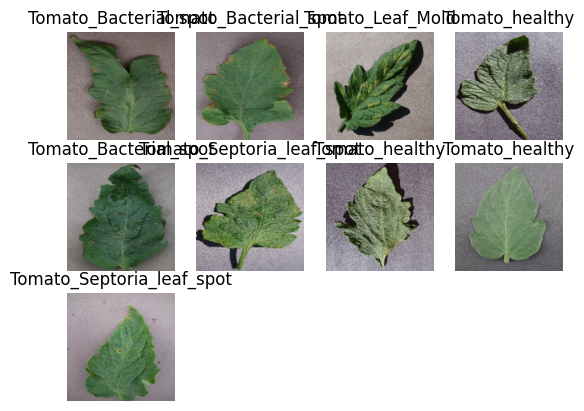

In [8]:
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
train_dataset = dataset.take(int(len(dataset)*0.8))
test_dataset = dataset.skip(len(train_dataset))
val_dataset = test_dataset.take(int(len(dataset)*0.1))
test_dataset = test_dataset.skip(len(val_dataset))

In [10]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1, test_split=0.1, shuffle = True, shuffle_size=100):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * len(ds))
    val_size = int(val_split * len(ds))
    train_dataset = ds.take(train_size)
    val_dataset=ds.skip(train_size).take(val_size)
    test_dataset=ds.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [11]:
train_dataset,test_dataset,val_dataset = get_dataset_partitions_tf(dataset)

In [12]:
train_dataset=train_dataset.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation=  resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape = (Batch_size,Image_size,Image_size, Channels)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,(3,3), padding="same", activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 128, 128, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 64, 64, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 62, 62, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 31, 31, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 29, 29, 32)         

In [17]:
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=2, min_lr=1e-7, min_delta=0.0004, mode='min')
early_stopping=EarlyStopping(monitor='val_loss', patience=5,start_from_epoch=3,restore_best_weights=True)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [19]:
history = model.fit(
    train_dataset,
    epochs=Epochs,
    batch_size  = Batch_size,
    callbacks = [early_stopping, reduce_lr],
    verbose = 1,
    validation_data=val_dataset
)

Epoch 1/50


2023-10-11 23:35:27.767121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-11 23:35:33.482410: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa73d14d8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-11 23:35:33.482453: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 960, Compute Capability 5.2
2023-10-11 23:35:33.503847: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-11 23:35:33.638611: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


266/267 [============================>.] - ETA: 0s - loss: 2.1591 - accuracy: 0.4191

2023-10-11 23:35:58.173470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1 of 100
2023-10-11 23:35:58.173633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


267/267 [==============================] - 45s 82ms/step - loss: 2.1555 - accuracy: 0.4198 - val_loss: 1.5622 - val_accuracy: 0.4738 - lr: 1.0000e-04
Epoch 2/50
267/267 [==============================] - 7s 26ms/step - loss: 1.2237 - accuracy: 0.5936 - val_loss: 1.1110 - val_accuracy: 0.6201 - lr: 1.0000e-04
Epoch 3/50
267/267 [==============================] - 7s 25ms/step - loss: 1.0150 - accuracy: 0.6629 - val_loss: 1.0795 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 4/50
267/267 [==============================] - 7s 26ms/step - loss: 0.8620 - accuracy: 0.7080 - val_loss: 0.8588 - val_accuracy: 0.7001 - lr: 1.0000e-04
Epoch 5/50
267/267 [==============================] - 7s 25ms/step - loss: 0.7441 - accuracy: 0.7422 - val_loss: 0.7537 - val_accuracy: 0.7323 - lr: 1.0000e-04
Epoch 6/50
267/267 [==============================] - 7s 26ms/step - loss: 0.6683 - accuracy: 0.7702 - val_loss: 0.8005 - val_accuracy: 0.7259 - lr: 1.0000e-04
Epoch 7/50
267/267 [==============================

In [20]:
scores = model.evaluate(test_dataset)

 3/33 [=>............................] - ETA: 1s - loss: 0.7854 - accuracy: 0.6771

2023-10-11 23:37:31.794511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:25: Filling up shuffle buffer (this may take a while): 1 of 100
2023-10-11 23:37:31.794638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


33/33 [==============================] - 13s 12ms/step - loss: 0.7103 - accuracy: 0.7576


In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

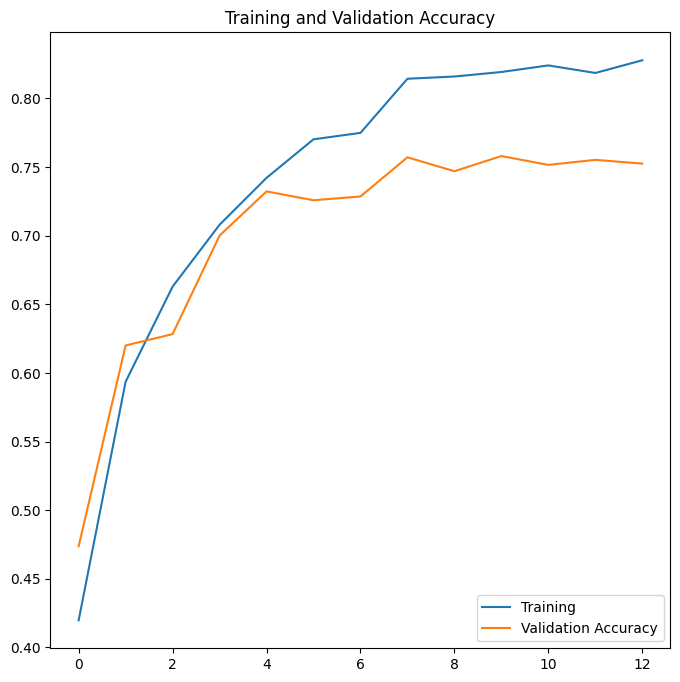

In [22]:
plt.figure(figsize=(8,8))
plt.plot(range(13), acc, label='Training')
plt.plot(range(13),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


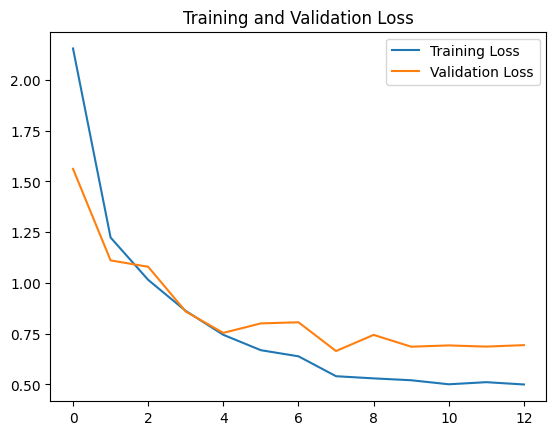

In [23]:
plt.plot(range(13), loss, label='Training Loss')
plt.plot(range(13),val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy)
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.maxa(predictions[0])), 2)
    return predicted_class, confidence

In [25]:
model_version=2
model.save(f"{model_version}")

INFO:tensorflow:Assets written to: 2/assets


INFO:tensorflow:Assets written to: 2/assets


In [ ]:
import os
os.listdir()

['directory for model1', 'Untitled-1.ipynb']

In [26]:
import keras_tuner
from keras.models import Sequential
from keras import Input

Using TensorFlow backend


In [27]:


def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(Image_size, Image_size, 3)))
    model.add(data_augmentation)
    model.add(resize_and_rescale)
    for i in range(hp.Int("num_layers", 3, 7, default=5)):
        kernel1 = hp.Int(f"kernel _{i}alpha", min_value=1, max_value=5, step=2, default=1)
        model.add(layers.Conv2D(hp.Int(f"units_{i}alpha", min_value=16, max_value=128, step=4, default=16), (kernel1,kernel1), padding="same", activation="relu"))
        if hp.Boolean(f"Conv2D{i}beta"):
            kernel2 = hp.Int(f"kernel_{i}beta", min_value=1, max_value=5, step=2, default=1)
            model.add(layers.Conv2D(hp.Int(f"units_{i}beta", min_value=16, max_value=128, step=4, default=32), (kernel2,kernel2), padding="same", activation="relu"))
        if hp.Boolean(f"Conv2D{i}gamma"):
            kernel3 = hp.Int(f"kernel_{i}gamma", min_value=1, max_value=5, step=2, default=1)
            model.add(layers.Conv2D(hp.Int(f"units_{i}gamma", min_value=16, max_value=128, step=4, default=64), (kernel3,kernel3), padding="same", activation="relu"))
        if hp.Boolean(f"BatchNormalization{i}"):
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten()),
    model.add(layers.Dense(hp.Int("dense1", min_value=32, max_value=1024, step=8, default=512), activation='relu'))
    if hp.Boolean("Dropout1"):
         model.add(layers.Dropout(hp.Float("Dropout1Rt", min_value=0.1, max_value=0.8, step=0.05, default=0.3)))
    model.add(layers.Dense(hp.Int("dense2", min_value=16, max_value=1024, step=8), activation='relu'))
    if hp.Boolean("Dropout2"):
         model.add(layers.Dropout(hp.Float("Dropout2Rt", min_value=0.1, max_value=0.8, step=0.05, default=0.3)))
    model.add(layers.Dense(n_classes, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
               metrics=['accuracy'])
    return model

In [28]:

build_model(keras_tuner.HyperParameters())
tuner = keras_tuner.Hyperband(build_model,
objective='val_accuracy',
max_epochs=40,
factor=3,
directory='test1',
project_name='vegetables'
)
early_stopping= EarlyStopping(monitor='val_loss', patience=10,start_from_epoch=3,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=3, min_lr=1e-10, min_delta=0.0004, mode='min')
tuner.search(train_dataset, epochs=50, validation_data=val_dataset, batch_size=Batch_size, use_multiprocessing = True, workers = 2, verbose=1, callbacks = [early_stopping, reduce_lr])
models = tuner.get_best_models(num_models=5)
model = models[0]
for i in range(len(models)):
    print(f"----------------------model{i}----------------------------")
    print(models[i].summary())

Trial 25 Complete [00h 00m 04s]

Best val_accuracy So Far: 0.8491260409355164
Total elapsed time: 00h 39m 36s

Search: Running Trial #26

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_layers
5                 |1                 |kernel _0alpha
116               |76                |units_0alpha
True              |False             |Conv2D0beta
False             |False             |Conv2D0gamma
True              |False             |BatchNormalization0
1                 |3                 |kernel _1alpha
76                |64                |units_1alpha
True              |False             |Conv2D1beta
False             |True              |Conv2D1gamma
False             |False             |BatchNormalization1
3                 |3                 |kernel _2alpha
32                |84                |units_2alpha
True              |True              |Conv2D2beta
True              |True              |Conv2D2gamma
False             |True      

2023-10-12 00:17:22.480704: W tensorflow/core/kernels/conv_ops_gpu.cc:144] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 32
in_depths: 3
out_depths: 116
in: 128
in: 128
data_format: 1
filter: 5
filter: 5
filter: 3
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 2
padding: 2
dtype: DT_FLOAT
group_count: 1
device_identifier: "sm_5.2 with 4294836224B RAM, 8 cores, 1278500KHz clock, 3505000KHz mem clock, 1048576B L2$"
fusion {
  activation_mode: kRelu
  conv_scale: 1
}
version: 3

2023-10-12 00:17:22.481243: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:625 : NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng11{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
Traceback (most recent call last):


RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/tensorflow/python/eager/execute.py", line 60, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node sequential/conv2d/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_66229/2602873395.py", line 11, in <module>

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 230, in search

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 270, in _try_run_and_update_trial

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 235, in _run_and_update_trial

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 144, in fit

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/activations.py", line 306, in relu

  File "/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/backend.py", line 5397, in relu

No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng11{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node sequential/conv2d/Relu}}]] [Op:__inference_train_function_202910]
